In [309]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot as plt
from autocorrect import Speller #autocorrector

In [ ]:
import umap
import seaborn as sns
import numpy as np
import pandas as pd
import re
import itertools

## Lectura del dataset "app_reviews"

In [310]:
review = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')
review

,package_name,review,date,star
0,com.mantz_it.rfanalyzer,Great app! The new version now works on my Bra...,October 12 2016,4
1,com.mantz_it.rfanalyzer,Great It's not fully optimised and has some is...,August 23 2016,4
2,com.mantz_it.rfanalyzer,Works on a Nexus 6p I'm still messing around w...,August 04 2016,5
3,com.mantz_it.rfanalyzer,The bandwidth seemed to be limited to maximum ...,July 25 2016,3
4,com.mantz_it.rfanalyzer,Works well with my Hackrf Hopefully new update...,July 22 2016,5
...,...,...,...,...
288060,com.termux.api,it doesn't do anything after installing this i...,June 24 2016,3
288061,com.termux.api,I like this app . Its is very helpful for use....,June 20 2016,5
288062,com.termux.api,Finally Brings back the Unix command line to A...,May 20 2016,5
288063,com.termux.api,The API feature is great just need loads more...,May 05 2016,5


## Limpieza del dataset 

In [311]:
def clean_corpus(corpus_review):
        
    for i in range(len(corpus_review)):        
        corpus_review[i] = re.sub(r'https?:\/\/.\S+', "", corpus_review[i]) 
        corpus_review[i] = re.sub(r'"', '', corpus_review[i]) 
        corpus_review[i] = re.sub(r'#', '', corpus_review[i]) 
        corpus_review[i] = re.sub(r'^RT[\s]+', '', corpus_review[i]) 
              
        Apos_dict={"'s":" is","n't":" not","'m":" am","'    ll":" will", 
               "'d":" would","'ve":" have","'re":" are"} #reemplazar apostrofes    
          
        for key,value in Apos_dict.items(): 
            if key in corpus_review[i]: 
                corpus_review[i]=corpus_review[i].replace(key,value) #reemplazar

        corpus_review[i] = " ".join([s for s in re.split("([A-Z][a-z]+[^A-Z]*)",corpus_review[i]) if s])
        corpus_review[i]=corpus_review[i].lower() #minusculas

        file=open("slang.txt","r") #jergas del ingles
        slang=file.read() 
          
        slang=slang.split('\n') 
          
        tweet_tokens= corpus_review[i].split() 
        slang_word=[] 
        meaning=[] 
          
        for line in slang: 
            temp=line.split("=") 
            slang_word.append(temp[0]) 
            meaning.append(temp[-1]) 
          
        for i,word in enumerate(tweet_tokens): 
            if word in slang_word: 
                idx=slang_word.index(word) 
                tweet_tokens[i]=meaning[idx] 
                  
        corpus_review[i]=" ".join(tweet_tokens) 
        corpus_review[i] = ''.join(''.join(s)[:2] for _, s in itertools.groupby(corpus_review[i]))   
 
        spell = Speller(lang='en') 
        corpus_review[i]=spell(corpus_review[i]) 
    return corpus_review
        

### Se extrae en un corpus todos los reviews o criticas de usuario

In [312]:
def extract_corpus(dataset):
    lista = []  
    for i in range(len(dataset['package_name'].unique())):
        dataset_temp = dataset.loc[dataset['package_name'] == dataset['package_name'].unique()[i]]
        lista.append({'package_name':dataset['package_name'].unique()[i], 'size': len(dataset_temp)})

    lista = sorted(lista, key=lambda x: x['size'], reverse=True)
    dataframe = dataset[dataset['package_name'] == lista[8]['package_name']]
    corpus = list(dataframe['review'])
    
    #corpus = clean_corpus(corpus)

    return corpus

### Del corpus extraido para cuestiones de darles pertenencia a un cluster, se crea un DataFrame

In [313]:
def convert_corpus_to_dataFrame(corpus):
    corpus_ds = {
        'Sentences' : corpus
    }

    dataset_new = pd.DataFrame(corpus_ds)
    return dataset_new

### Se crea una función que nos permita incrustar las oraciones, para esto usamos un modelo pre-entrenado de SBERT

In [314]:
def neural_embeddings(dataset):
    model_embedder = SentenceTransformer('all-MiniLM-L6-v2')
    corpus = extract_corpus(dataset)

    embeddings = model_embedder.encode(corpus, convert_to_tensor=True, show_progress_bar=True)
    embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True)

    return embeddings, corpus

### Para dar visualización de estas oraciones en un plano euclidiano, aplicamos una técnica de reducción de dimensiones 

In [315]:
def dimension_reduction(embeddings):
    scaler = umap.UMAP(n_components=2).fit_transform(embeddings)
    dimension_2d = pd.DataFrame(scaler, columns=['x', 'y'])
    return dimension_2d

### Para obtener el "mejor" cluster aplicamos el método de la silueta

In [316]:
def silhoutte(dataset, attempts):

    embeddings, corpus = neural_embeddings(dataset)
    scores_silhouette = []

    for k in range(2,attempts):

        agglomerative_clusterering = AgglomerativeClustering(n_clusters=k, affinity="cosine" , linkage="complete").fit(embeddings)
        cluster_labels = agglomerative_clusterering.labels_

        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        scores_silhouette.append(silhouette_avg)

    max_score = max(scores_silhouette)
    max_index = scores_silhouette.index(max_score)
    n_clusters = max_index + 2

    return n_clusters, embeddings, corpus

### Al tener el "mejor" número de clusters, se procede a segmentar las oraciones

In [317]:
def segmentation(dataset_review, attempts):
    n_clusters, embeddings, corpus = silhoutte(dataset_review, attempts)

    agglomerative_clusterering = AgglomerativeClustering(n_clusters=n_clusters, affinity="cosine" , linkage="complete").fit(embeddings)
    cluster_labels = agglomerative_clusterering.labels_

    return cluster_labels, embeddings, corpus

### A cada oración le asignamos el cluster al que pertenece

In [318]:
def clustering(dataset_review, attempts):
    labels, embeddings, corpus = segmentation(dataset_review, attempts)
    
    corpus_dataframe = convert_corpus_to_dataFrame(corpus)
    corpus_dataframe['cluster'] = labels
    #corpus_dataframe = corpus_dataframe.sort_values(by=['cluster'])

    return labels, embeddings, corpus_dataframe

### Mostraremos un gráfico de la segmentación de oraciones y un DataFrame de las oraciones con su respectivo cluster 

In [319]:
def show_graphics_and_themes(dataset_review, attemps):

    labels_HAC, embeddings, segment_review = clustering(dataset_review, attemps)
    review_2d = dimension_reduction(embeddings)

    review_2d['labels'] = labels_HAC
    
    plt.figure(figsize=(14, 8))
    clustered = review_2d[review_2d.labels != -1]
    plt.scatter(review_2d.x, review_2d.y, c=clustered.labels, s=20, cmap='Spectral')
    plt.colorbar()
    plt.show()

    return segment_review

In [320]:
def show_dimentions(distribution):
    for col in 'xy':
        sns.kdeplot(distribution[col], shade=True)

    with sns.axes_style(style='ticks'):
       g = sns.factorplot(data=distribution, kind="box")

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

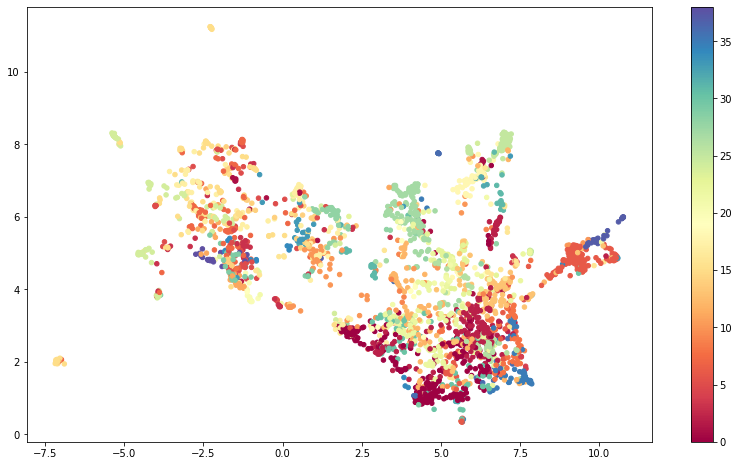

                                              Sentences  cluster
0                                 Authentication Morris        0
1     I can't access my account We couldn't verify y...        2
2     This app works fine Later found the secret key...       13
3                                     very good love it       24
4       Powerful app Awesome app to safe my transaction       30
...                                                 ...      ...
2971                              I'm feeling very well       17
2972              Doesn't work  can't add any accounts.        2
2973  Only one concern but not sure if it was the ap...       22
2974                                           Verygood        7
2975  This is very bad and not change password and v...        2

[2976 rows x 2 columns]


In [321]:
print(show_graphics_and_themes(review, 40))